#### - Fig. 3: Transect through the intrusion with model or over seal transect. Look for nice one.

### I am setting this up to run with seal 15, but I am not sure this is gonna work because there wasnt mCDW on that transect

In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import cartopy.crs as ccrs
import matplotlib.path as mpath
import xarray as xr
import cmocean.cm as cmocean
from collections import OrderedDict
import cftime
import glob,os
import matplotlib.colors as col
import xarray.ufuncs as xu
import gsw

import logging
logging.captureWarnings(True)
logging.getLogger('py.warnings').setLevel(logging.ERROR)

from dask.distributed import Client

# set to your figure directory location:
#figdir = '/g/data/v45/akm157/figures/Antarctic_tides_fixed/temp_transect_movie/'

In [3]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40097/status,
Dashboard: /proxy/40097/status,Workers: 7
Total threads: 28,Total memory: 125.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42557,Workers: 7
Dashboard: /proxy/40097/status,Total threads: 28
Started: Just now,Total memory: 125.18 GiB
Comm: tcp://127.0.0.1:35491,Total threads: 4
Dashboard: /proxy/44795/status,Memory: 17.88 GiB
Nanny: tcp://127.0.0.1:33863,


In [4]:
master_session = cc.database.create_session('/g/data/ik11/databases/cosima_master.db')
cycle3 = '01deg_jra55v140_iaf_cycle3'

first_year = '1958'
last_year = '2018'

start_time=first_year+'-01-01'
end_time=last_year+'-12-31'

# set this to the rough region of interest:
lon_slice  = slice(-258, -248)
lat_slice  = slice(-67.5, -61)

In [5]:
# get temp and salt to calculate lines:
temp = cc.querying.getvar(cycle3,'temp',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly') - 273.15
temp = temp.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

salt = cc.querying.getvar(cycle3,'salt',master_session,
                 start_time=start_time, end_time=end_time,frequency='1 monthly')
salt = salt.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)

#### Plot map of chosen transect

In [6]:
# load a sample slice of data to plot just for testing:
#temp_slice = temp.sel(st_ocean=400,method='nearest').isel(time=0)
temp_slice = temp.sel(st_ocean=400,method='nearest').mean('time')
temp_slice = temp_slice.load()

# import bathymetry and the land/ocean mask to add to plot:
ht = cc.querying.getvar(cycle3,'ht' , master_session,n=1)
ht = ht.sel(yt_ocean=lat_slice).sel(xt_ocean=lon_slice)
# create land mask from the bathymetry:
land_mask = np.squeeze(ht.values)*0
land_mask[np.isnan(land_mask)]=1
land_mask = np.where(land_mask==1,land_mask,np.nan)

Text(0, 0.5, 'Latitude ($^\\circ$)')

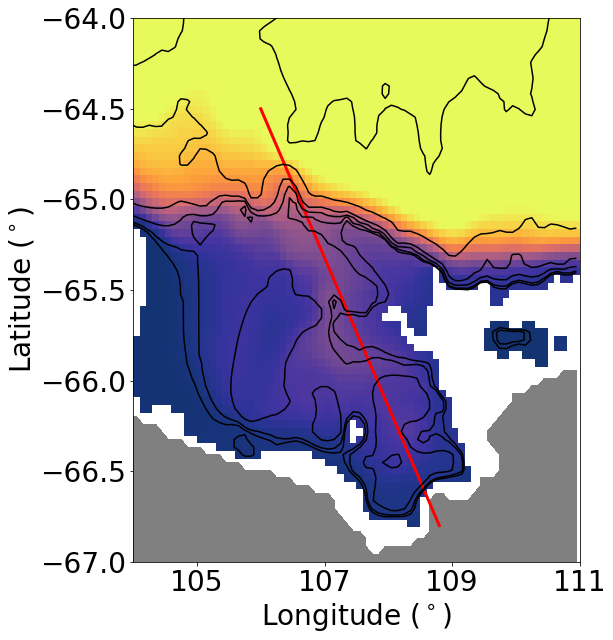

In [7]:
# define transect start and end points:
# Change these values until you get the transect you want:
lat0 = -66.8
lat1=  -64.5
lon0 = -250.2
lon1 = -253 #-254

fontsize=28

fig=plt.figure(figsize=(10,10))
ax0=plt.subplot(1,1,1)  
# plot temperature:
plt.pcolormesh(temp_slice.xt_ocean,temp_slice.yt_ocean,temp_slice, cmap=cmocean.thermal,
              vmin=-2,vmax=0)
cbar=plt.colorbar()
#plt.clim((-2.1,.8))

# plot transect location:
plt.plot([lon0,lon1],[lat0,lat1],'r',linewidth='3')
plt.xlim((-255, -248))
plt.ylim((-67, -64))
# plot bathymetry contours:
plt.contour(ht.xt_ocean,ht.yt_ocean,ht,[500,550,700,1000,2000,3000],colors='k')
plt.contourf(ht.xt_ocean,ht.yt_ocean,land_mask,colors='grey')
plt.tick_params(labelsize=fontsize)

cbar.ax.tick_params(labelsize=18)
cbar.ax.tick_params(labelsize=18)
cbar.set_label(r'Temperature ($^\circ$C)', fontsize = 18,labelpad=5)
# this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

ax0.set_xticklabels([-256+359,-254+359,-252+359,-250+359,-248+359])
plt.xlabel('Longitude ($^\circ$)',fontsize=fontsize)
plt.ylabel('Latitude ($^\circ$)',fontsize=fontsize)

#figdir = '/home/581/ns3783/Scripts/Figures/New_codes_CFD/Figures'
#filestr = figdir+'/Fig2_map.png'
#plt.savefig(filestr,dpi=600,bbox_inches='tight')

In [8]:
#temp

### extract nearest points along transect 

In [9]:
# Note that this cell is slow, but it will load the entire timeseries along the transect 
# (which means you could later make movies of this or look at different snapshots):
#this is wrong for salt and T because I have avg them

lons = [lon0, lon1]
lats = [lat0, lat1]

yt_ocean = temp.yt_ocean

# get latitude of points along transect:
lat_transect = yt_ocean.sel(yt_ocean = slice(lats[0],lats[1])).values

# calculate slope and intercept of transect line:
slope = (lons[0] - lons[1])/(lats[0]-lats[1])
intercept = lons[0] - slope * lats[0]

# get longitude along transect and convert to xarray:
lon_transect = slope * lat_transect + intercept
lon_transect = xr.DataArray(lon_transect, dims = 'yt_ocean')

# convert to xarray:
lat_transect = xr.DataArray(lat_transect, dims = 'yt_ocean')

# Extract temp and salt along transect:
temp_transect = temp.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
salt_transect = salt.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')

# bathymetry along transect:
ht_transect = ht.sel(xt_ocean = lon_transect, yt_ocean = lat_transect, method = 'nearest')
ht_transect = ht_transect.fillna(0)

# calculate density along transect:
# arrays for gsw to use
depth_array = temp_transect*0 + temp_transect.st_ocean
lat_array = temp_transect*0 + temp_transect.yt_ocean
# need to convert practical salinity to absolute salinity:
pressure = gsw.p_from_z(-depth_array,lat_array)
# need to convert practical salinity to absolute salinity:
salt_abs = gsw.SA_from_SP(salt_transect,pressure,lon_transect,lat_array)
sigma0 = gsw.sigma0(salt_abs,temp_transect)
# convert back to xarray for multiplying later:
sigma0 = xr.DataArray(sigma0,
                      coords = [temp_transect.time, temp_transect.st_ocean,temp_transect.yt_ocean],
                      dims = ['time','st_ocean','yt_ocean'])

In [10]:
# load data before plotting:
sigma0 = sigma0.load()
temp_transect = temp_transect.load()
#u_speed_trans = u_speed_trans.load()
#v_speed_trans = v_speed_trans.load()

## Here we can extract the points leading up to high peaks and the points leading down to low peaks 

### loading indexes previously calculated by "Selecting_peak_low_years" code stored in /Figures/New_codes_CFD

In [11]:
outpath = '/g/data/v45/ns3783/top_index.nc'
profile_data = xr.open_dataset(outpath)
top_id = profile_data.top_id

In [12]:
outpath = '/g/data/v45/ns3783/bottom_index.nc'
profile_data = xr.open_dataset(outpath)
bt_id = profile_data.bt_id

In [13]:
np.size(bt_id)

135

### creating the averages for peaks and lows

In [14]:
sigma0_high=sigma0[top_id].mean('time')
temp_high=temp_transect[top_id].mean('time')

sigma0_low=sigma0[bt_id].mean('time')
temp_low=temp_transect[bt_id].mean('time')

### loading variables for peaks and lows

In [15]:
sigma0_high = sigma0_high.load()
sigma0_low = sigma0_low.load()

temp_high = temp_high.load()
temp_low = temp_low.load()

In [16]:
from matplotlib.cm import ScalarMappable

### plot is for years leading up to high peaks and leading up to low peaks

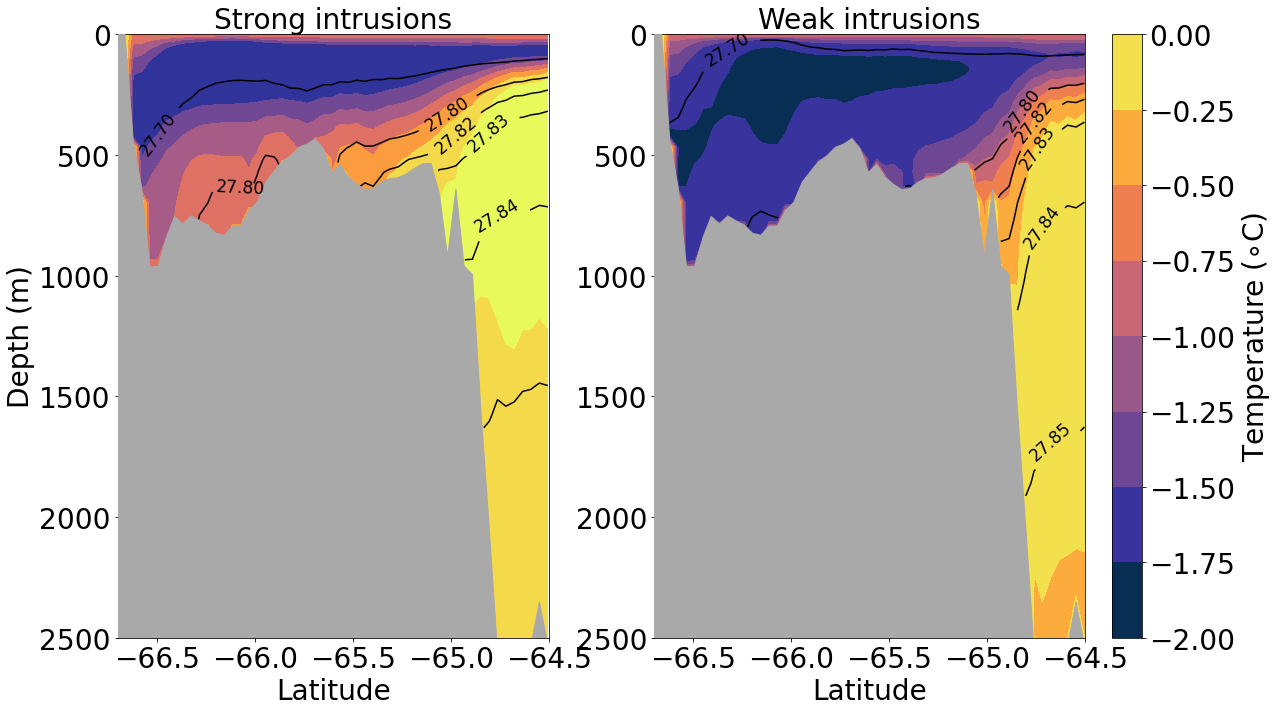

In [17]:
fontsize2 = 28
# choose density contours that work for your transect:
#density_contours = [27.7,27.8,27.83,27.84,27.85,27.9,28]
density_contours = [27.7,27.8,27.82,27.83,27.84,27.85,27.9,28]

# set up figure and projection:
fig = plt.figure(1,figsize=(18,10))
fig.subplots_adjust(top=0.88)

ax0=plt.subplot(1,2,1) 
# plot temperature:
pcm = plt.contourf(temp_high.yt_ocean,temp_high.st_ocean,temp_high.fillna(0),
           cmap = cmocean.thermal,vmin=-2,vmax=0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:ww
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude',fontsize=fontsize2)
plt.title('Strong intrusions',fontsize=fontsize2)
#cbar=plt.colorbar()
cbar=fig.colorbar(
   ScalarMappable(norm=pcm.norm, cmap=pcm.cmap),
   ticks=range(-2,0)
)

cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)
#this removes colorbar whilst maintaing figure size
fig.delaxes(fig.axes[1])

# plot density contours:
cont = plt.contour(sigma0_high.yt_ocean,sigma0_high.st_ocean,sigma0_high,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=17,fmt='%1.2f')

# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')


ax1=plt.subplot(1,2,2)   
# plot temperature:
pcm = plt.contourf(temp_low.yt_ocean,temp_low.st_ocean,temp_low.fillna(0),
           cmap = cmocean.thermal,vmin=-2,vmax=0)

plt.tick_params(labelsize=fontsize2)
plt.gca().invert_yaxis()
# set depth and latitude limits of plot:
plt.ylim((2500,0))
plt.xlim((-66.7,-64.5))
#plt.ylabel('Depth (m)',fontsize=fontsize2)
plt.xlabel('Latitude',fontsize=fontsize2)
plt.title('Weak intrusions',fontsize=fontsize2)
# colorbar:
#cbar=plt.colorbar(pcm, ticks = ticks,pad=.03)
cbar=plt.colorbar()
cbar.ax.tick_params(labelsize=fontsize2)
cbar.set_label(r'Temperature ($\circ$C)', fontsize = fontsize2,labelpad=5)

# plot density contours:
cont = plt.contour(sigma0_low.yt_ocean,sigma0_low.st_ocean,sigma0_low,density_contours,
           colors='k',zorder=2 ,fontsize=17)
plt.clabel(cont, inline=1, fontsize=17,fmt='%1.2f')


# plot land:
plt.fill_between(ht_transect.yt_ocean,ht_transect,6000,zorder=3,color='darkgrey')

fig.tight_layout()
figdir = '/g/data/v45/ns3783/ScriptsChapter3/Figures'
filestr = figdir+'/Fig2_transect.png'
plt.savefig(filestr,dpi=600,bbox_inches='tight')